# Ferret data
First, we load the imaging data used in Macke et al. (2011). Its size is (npixels_x, npixels_y, conditions, trials).

In [1]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt

data = scipy.io.loadmat('data/ferretdata.mat')
data = data['dat'] # data is stored in a dict
data.shape

(126, 252, 8, 100)

Reshape the data to (conditions, trials, npixels_x, npixels_y) and take a 40x40 pixel patch.

In [17]:
R = np.transpose(data[26:,:200,:,:], (2,3,0,1))
print(R.shape)

# take only a small part of the image (for performance reasons)
R = R[:,:,38:78,106:186]

# downsample image
#R = R[:,:,::3,::3]

R.shape

(8, 100, 100, 200)


(8, 100, 40, 80)

## Plot responses
Visualize the responses for the small patch

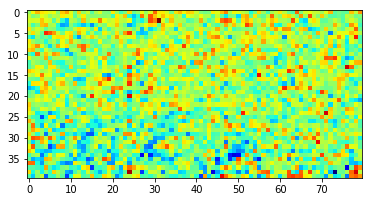

In [18]:
plt.imshow(R[0,np.random.randint(100),:,:], cmap='jet')

## Maximum likelihood solution
Compute the solution using vector averaging (for details see OPM.ipynb)

In [19]:
from opm import calculate_map, plot_opm, plot_amplitude_map
from response import create_stimuli

In [20]:
angles = [i * np.pi / 4 for i in range(4)]*2

V = create_stimuli([1.], angles, 100)
V.shape

(8, 100, 3)

In [21]:
m = calculate_map(R, V)
m_hat = m[0] + 1j * m[1]

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd84a90ecc0>)

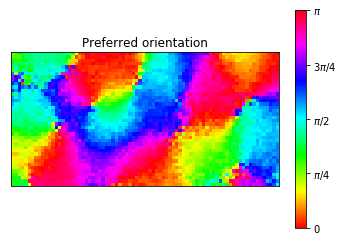

In [22]:
plot_opm(m_hat)

## Gaussian Process method
Compute a smooth OPM using the GP method (see BayesianOPM.ipynb)

In [31]:
from gp import GaussianProcessOPM

In [37]:
gp = GaussianProcessOPM(size=R.shape[2:], prior_method='icd', prior_rank=200)

In [38]:
mu_post = gp.fit(stimuli=V, responses=R, noise='factoran', verbose=True, noise_kwargs={'iterations':3})

*** Estimating prior hyperparameters ***
{'sigma': 5.477007891298554, 'alpha': 4.418939477653832}
*** Fitting prior ***
*** Fitting posterior ***


In [1]:
mu_post.shape

NameError: name 'mu_post' is not defined

In [39]:
mu_post.reshape(*R.shape[2:], 3).shape

(40, 80, 3)

In [40]:
mu = mu_post.reshape(3, *R.shape[2:])
result = mu[0] + 1j * mu[1]
A = np.abs(result)

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd8497964e0>)

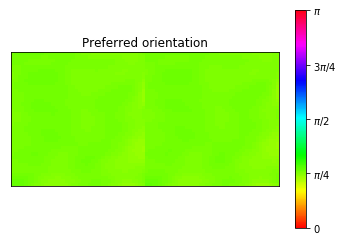

In [41]:
plot_opm(result)

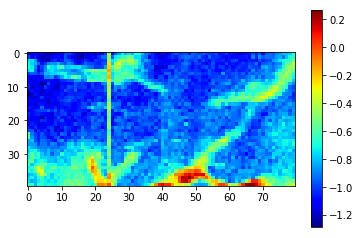

In [29]:
plt.imshow(np.log(np.diag(gp.noise_cov).reshape(*R.shape[2:])), cmap='jet')
plt.colorbar()